In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

2024-04-29 23:28:01.272278: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Data

In [14]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

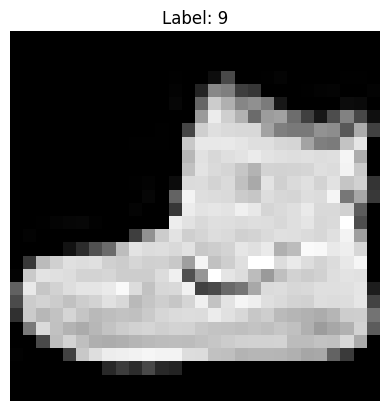

In [15]:
plt.imshow(x_train[0], cmap='gray')
plt.title(f'Label: {y_train[0]}')
plt.axis('off')
plt.show()

In [16]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

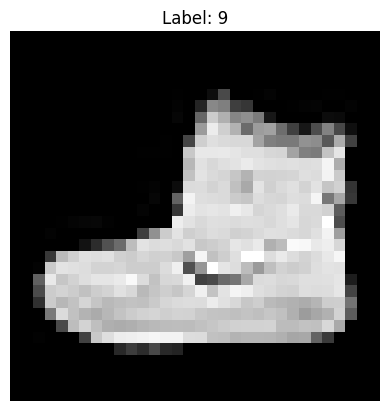

In [18]:
plt.imshow(x_train[0], cmap='gray')
plt.title(f'Label: {y_train[0]}')
plt.axis('off')
plt.show()

# 2. Encoder

In [22]:
x_train[0].shape

(32, 32, 1)

In [29]:
encoder_input = layers.Input(shape=x_train[0].shape, name='e_input')
x = layers.Conv2D(32, (3,3), 2,'same', activation = 'relu')(encoder_input)
x = layers.Conv2D(64, (3,3), 2,'same', activation = 'relu')(x)
x = layers.Conv2D(128, (3,3), 2,'same', activation = 'relu')(x)

shape_before_flattening = K.int_shape(x)[1:] # shape of the tensor

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name='e_output')(x)

encoder = models.Model(encoder_input,encoder_output)

In [30]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 e_input (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 e_output (Dense)            (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

In [31]:
shape_before_flattening

(4, 4, 128)

In [34]:
np.prod(shape_before_flattening) == 4*4*128

True

# 3. Decoder

In [37]:
decoder_input = layers.Input(shape=(2,), name='d_input')
x = layers.Dense(np.prod(shape_before_flattening) )(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3,3), 2,'same', activation = 'relu')(x)
x = layers.Conv2DTranspose(64, (3,3), 2,'same', activation = 'relu')(x)
x = layers.Conv2DTranspose(32, (3,3), 2,'same', activation = 'relu')(x)
decoder_output = layers.Conv2D(1,(3,3), 1, 'same', activation = 'sigmoid',name='d_output')(x)
decoder = models.Model(decoder_input, decoder_output)

In [38]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d_input (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846